In [16]:
import numpy as np
import pandas as pd	
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
import datetime
import keras_tuner as kt


In [17]:

'''fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()'''
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [18]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
    model.add(tf.keras.layers.Dense(units=hp.Int('units_1', min_value=320, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=320, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
from kerastuner.tuners import RandomSearch

'''model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])
'''

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,  # Number of hyperparameter combinations to try
    executions_per_trial=3,  # Number of times to evaluate each combination
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


Trial 15 Complete [00h 01m 26s]
val_accuracy: 0.9103333353996277

Best val_accuracy So Far: 0.9728000164031982
Total elapsed time: 00h 27m 32s


In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 320)            │       251,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,802 (1022.66 KB)

 Trainable params: 261,802 (1022.66 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

y_pred = model.predict(X_test)
accuracy_score(y_test, np.argmax(y_pred, axis=-1))

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4620 - loss: 1.8623 - val_accuracy: 0.8624 - val_loss: 0.7480
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8408 - loss: 0.7115 - val_accuracy: 0.9048 - val_loss: 0.4245
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8762 - loss: 0.4841 - val_accuracy: 0.9178 - val_loss: 0.3315
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8887 - loss: 0.4072 - val_accuracy: 0.9260 - val_loss: 0.2898
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9026 - loss: 0.3576 - val_accuracy: 0.9276 - val_loss: 0.2649
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9096 - loss: 0.3230 - val_accuracy: 0.9320 - val_loss: 0.2488
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9111 - loss: 0.3133 - val_accuracy: 0.9358 - val_loss: 0.2351
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9167 - loss: 0.2970 - 

0.9652

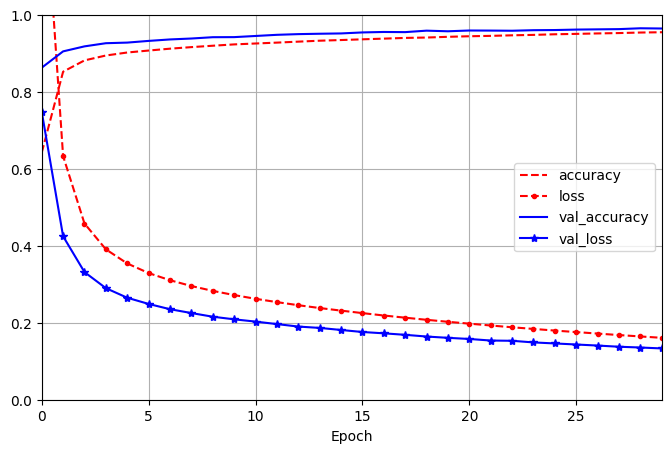

In [22]:
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()